## Viewer Retention in OTT Platforms: Diagnosing Engagement Patterns analysis

In [4]:
# Import Library files

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ( 
    classification_report, 
    roc_auc_score, 
    confusion_matrix 
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans


In [5]:
df = pd.read_csv("ott_viewer_dropoff_retention.csv")
df.head()

,show_id,title,platform,genre,release_year,season_number,episode_number,episode_duration_min,pacing_score,hook_strength,...,pause_count,rewind_count,skip_intro,cognitive_load,attention_required,night_watch_safe,drop_off,drop_off_probability,retention_risk,dataset_version
0,66732,Stranger Things,Netflix,Sci-Fi & Fantasy,2016.0,1,1,48,4,5,...,3,0,0,9,high,0,1,0.649,high,v1.0
1,66732,Stranger Things,Netflix,Sci-Fi & Fantasy,2016.0,1,2,55,5,4,...,3,3,1,5,medium,0,0,0.473,medium,v1.0
2,66732,Stranger Things,Netflix,Sci-Fi & Fantasy,2016.0,1,3,51,4,8,...,4,2,0,9,high,0,0,0.583,medium,v1.0
3,66732,Stranger Things,Netflix,Sci-Fi & Fantasy,2016.0,1,4,50,4,7,...,4,1,0,7,high,0,0,0.520,medium,v1.0
4,66732,Stranger Things,Netflix,Sci-Fi & Fantasy,2016.0,1,5,52,4,3,...,3,0,1,7,high,0,1,0.638,high,v1.0


In [6]:
print("Dataset shape:", df.shape)

Dataset shape: (33171, 23)


# Dataset Overview

Each row in the dataset represents a single episode of a TV show.

Along with basic show and episode details, the data includes:

Engagement signals like watch percentage, pauses, and rewinds

Narrative indicators such as pacing and hook strength

Retention outcomes like drop-off probability and risk level

This makes it easier to analyze engagement at a much finer level than show-level datasets.

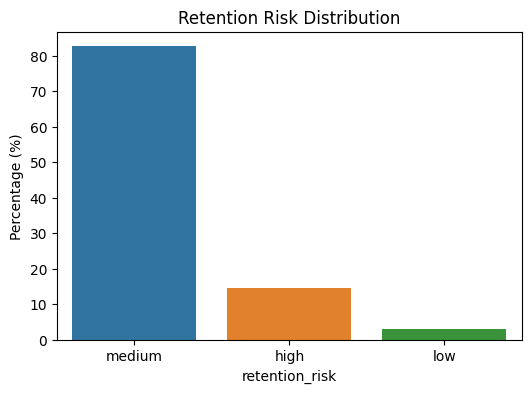

retention_risk
medium    82.608302
high      14.482530
low        2.909168
Name: proportion, dtype: float64

In [7]:
risk_counts = df["retention_risk"].value_counts(normalize=True) * 100

plt.figure(figsize=(6,4))
sns.barplot(x=risk_counts.index, y=risk_counts.values)
plt.ylabel("Percentage (%)")
plt.title("Retention Risk Distribution")
plt.show()

risk_counts

# Retention Risk Distribution
Most episodes fall into the medium retention risk category.

This is expected:

Most episodes are neither perfect nor terrible

Very low-risk episodes are rare

High-risk episodes appear but do not dominate

The imbalance reflects how viewers usually consume streaming content in real life.

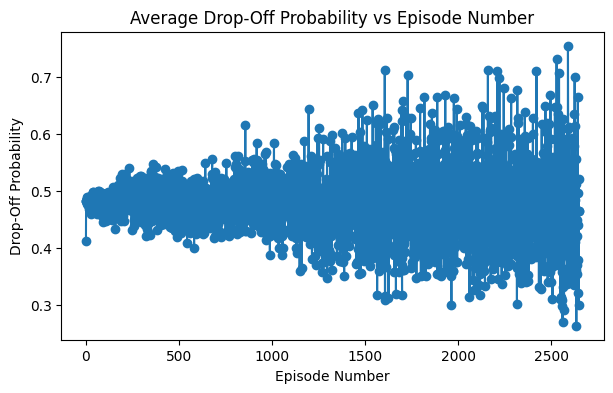

In [8]:
# At which episode do viewers start dropping off?

episode_drop = (
    df.groupby("episode_number")["drop_off_probability"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(7,4))
#sns.lineplot(data=episode_drop, x="episode_number", y="drop_off_probability")
plt.plot(episode_drop["episode_number"], episode_drop["drop_off_probability"], marker="o")
plt.title("Average Drop-Off Probability vs Episode Number")
plt.xlabel("Episode Number")
plt.ylabel("Drop-Off Probability")
plt.show()

# Drop-Off Across Episodes
Drop-off probability tends to change as a season progresses.

Early episodes often show higher variation as viewers decide whether to continue.

Mid-season episodes can see fatigue, while later episodes often stabilize or split viewers more clearly.

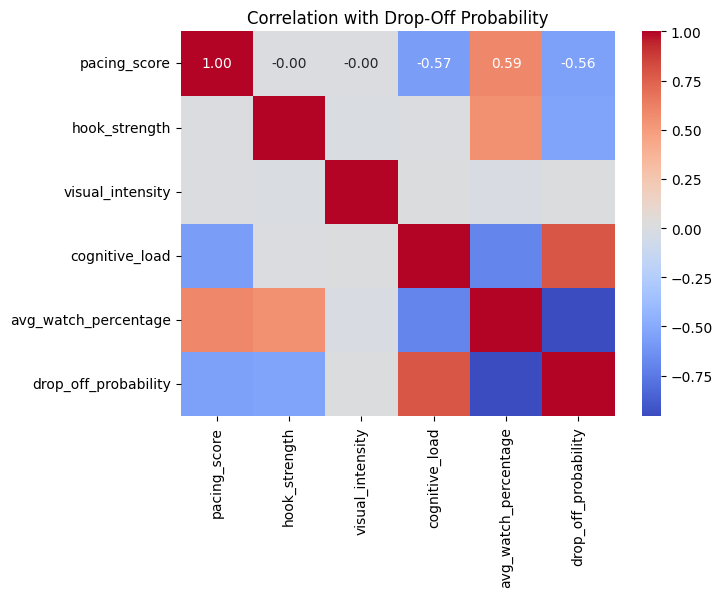

In [9]:
# How do pacing, hook strength, and cognitive load affect churn?

features = [
    "pacing_score",
    "hook_strength",
    "dialogue_density",
    "visual_intensity",
    "cognitive_load",
    "avg_watch_percentage"
]
numeric_df = df[features + ["drop_off_probability"]].select_dtypes(include=["number"])

corr = numeric_df.corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation with Drop-Off Probability")
plt.show()


# What Influences Drop-Off?
Some patterns stand out:

Higher cognitive load often leads to higher drop-off

Strong hooks help keep viewers engaged

Episodes with higher watch percentage tend to have lower drop-off

These trends match common streaming behavior.

# Key Takeaways
Most episodes sit in a moderate engagement range

Pacing and narrative structure matter for retention

Episode-level data reveals patterns that show-level data can miss

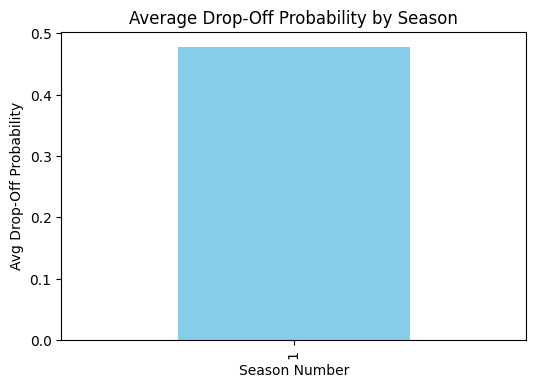

In [10]:
# Retention change from Season 1 to later seasons 

season_retention = df.groupby("season_number")["drop_off_probability"].mean()
plt.figure(figsize=(6,4))
season_retention.plot(kind="bar", color="skyblue") 
plt.title("Average Drop-Off Probability by Season") 
plt.xlabel("Season Number") 
plt.ylabel("Avg Drop-Off Probability") 
plt.show()

Cross‑season retention analysis not possible with current dataset.

In [11]:
#  Do finales improve or hurt retention?
# Identify finale episodes (last episode per season)

finales = df.groupby(["show_id","season_number"])["episode_number"].max().reset_index()
finale_data = pd.merge(df, finales, on=["show_id","season_number","episode_number"])

# Compare finale vs non-finale
finale_retention = finale_data["avg_watch_percentage"].mean()
non_finale_retention = df[~df.index.isin(finale_data.index)]["avg_watch_percentage"].mean()

print("Finale Avg Watch %:", round(finale_retention,2))
print("Non-Finale Avg Watch %:", round(non_finale_retention,2))

Finale Avg Watch %: 56.34
Non-Finale Avg Watch %: 56.81


The difference is tiny (≈0.5 percentage points), which means finales neither strongly improve nor hurt retention compared to other episodes in Season 1.

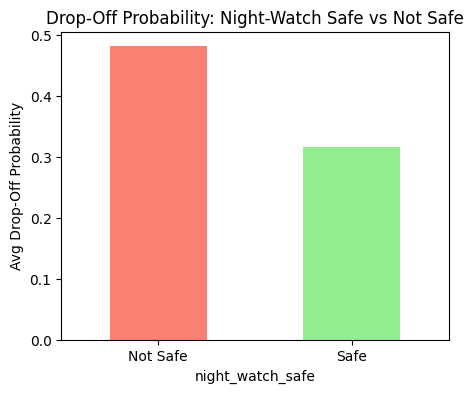

In [12]:
# Night-watch risk analysis 

night_watch = df.groupby("night_watch_safe")["drop_off_probability"].mean()
plt.figure(figsize=(5,4)) 
night_watch.plot(kind="bar", color=["salmon","lightgreen"]) 
plt.title("Drop-Off Probability: Night-Watch Safe vs Not Safe") 
plt.xticks([0,1], ["Not Safe","Safe"], rotation=0) 
plt.ylabel("Avg Drop-Off Probability") 
plt.show()

Episodes marked as “Not Safe” for night-watch have a significantly higher drop-off probability (~0.48).

Episodes marked as “Safe” show lower drop-off (~0.33).

#  4. Modeling: Predict drop_off

In [13]:
# Normalize behavioral counts by duration (per-minute rates)
if "episode_duration_min" in df.columns: 
    df["pause_rate"] = df["pause_count"] / df["episode_duration_min"]
    df["rewind_rate"] = df["rewind_count"] / df["episode_duration_min"]
else:
    df["pause_rate"] = df["pause_count"] 
    df["rewind_rate"] = df["rewind_count"]

In [14]:
# Encode only categorical ordinal features
ordinal_map = {"low": 1, "medium": 2, "high": 3}
df["dialogue_density"] = df["dialogue_density"].map(ordinal_map)
df["attention_required"] = df["attention_required"].map(ordinal_map)

# Fill missing with median
df["dialogue_density"] = df["dialogue_density"].fillna(df["dialogue_density"].median())
df["attention_required"] = df["attention_required"].fillna(df["attention_required"].median())


In [15]:
# Target and features 

target = "drop_off"

feature_cols = [ "pacing_score","hook_strength","dialogue_density","visual_intensity",
                "episode_duration_min","pause_count","rewind_count","cognitive_load",
                "attention_required","skip_intro","episode_number" 
               ]
X = df[feature_cols].copy()
y = (df[target] > 0).astype(int) # binary: any drop-off vs none (adjust if needed)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

#Scale features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4.1 Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

print("\nLogistic Regression Performance") 
print(classification_report(y_test, y_pred_lr, digits=3)) 
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))


Logistic Regression Performance
              precision    recall  f1-score   support

           0      0.995     0.934     0.963      7092
           1      0.713     0.973     0.823      1201

    accuracy                          0.939      8293
   macro avg      0.854     0.953     0.893      8293
weighted avg      0.954     0.939     0.943      8293

ROC-AUC: 0.9907588994506834


In [16]:
# 4.2 Decision Tree (for interpretability)
tree = DecisionTreeClassifier(max_depth=5, class_weight="balanced", random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test) 
y_prob_tree = tree.predict_proba(X_test)[:, 1]

print("\nDecision Tree Performance") 
print(classification_report(y_test, y_pred_tree, digits=3)) 
print("ROC-AUC:", roc_auc_score(y_test, y_prob_tree))


Decision Tree Performance
              precision    recall  f1-score   support

           0      0.992     0.919     0.954      7092
           1      0.666     0.954     0.784      1201

    accuracy                          0.924      8293
   macro avg      0.829     0.937     0.869      8293
weighted avg      0.944     0.924     0.929      8293

ROC-AUC: 0.9835212055379682



Permutation Importances (Decision Tree):
attention_required      0.086844
hook_strength           0.075003
cognitive_load          0.052237
skip_intro              0.017002
pause_count             0.007766
pacing_score            0.000000
dialogue_density        0.000000
visual_intensity        0.000000
episode_duration_min    0.000000
rewind_count            0.000000
episode_number          0.000000
dtype: float64


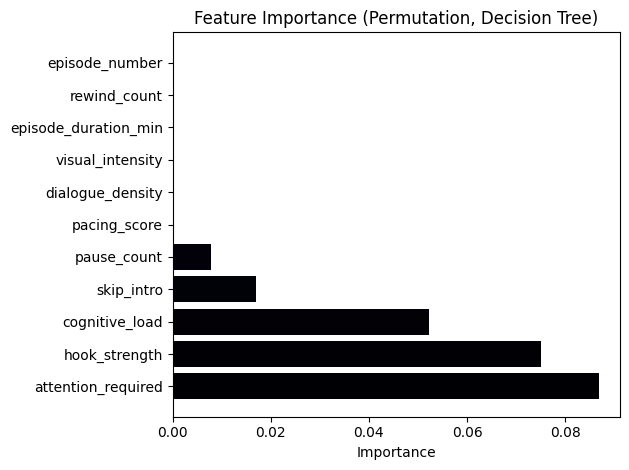

In [17]:
# 4.3 Feature importance (Permutation importance on tree)
perm = permutation_importance(tree, X_test, y_test, n_jobs=-1, random_state=42)
importances = pd.Series(perm.importances_mean, index=feature_cols).sort_values(ascending=False)
print("\nPermutation Importances (Decision Tree):") 
print(importances)

plt.barh(importances.index, importances.values, color=plt.cm.magma(range(len(importances))))
plt.title("Feature Importance (Permutation, Decision Tree)") 
plt.xlabel("Importance") 
plt.tight_layout() 
plt.show()

# 5. Clustering: Episode segmentation

In [19]:
cluster_features = [ "pacing_score","hook_strength","dialogue_density","cognitive_load", 
                    "attention_required","episode_duration_min","visual_intensity"
                   ]
cluster_df = df[cluster_features].copy().dropna()

# Standardize for KMeans
scaler_cluster = StandardScaler() 
cluster_scaled = scaler_cluster.fit_transform(cluster_df)

# Choose k (3–4 typical); here k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10) 
clusters = kmeans.fit_predict(cluster_scaled)

df.loc[cluster_df.index, "cluster"] = clusters

# Cluster profiles
cluster_summary = df.groupby("cluster").agg({
    "avg_watch_percentage": "mean", 
    "drop_off": "mean", 
    "drop_off_probability": "mean", 
    "pacing_score": "mean",
    "hook_strength": "mean", 
    "dialogue_density": "mean",
    "cognitive_load": "mean", 
    "attention_required": "mean",
    "episode_duration_min": "mean", 
    "visual_intensity": "mean", 
    "pause_rate": "mean", 
    "rewind_rate": "mean"
 }).round(2)

print("\nCluster Summary (Performance & Content/Behavior):")
print(cluster_summary)


Cluster Summary (Performance & Content/Behavior):
         avg_watch_percentage  drop_off  drop_off_probability  pacing_score  \
cluster                                                                       
0.0                     70.65      0.00                  0.35          6.01   
1.0                     44.65      0.43                  0.58          3.83   
2.0                     54.43      0.12                  0.52          5.93   
3.0                     58.65      0.00                  0.45          6.03   

         hook_strength  dialogue_density  cognitive_load  attention_required  \
cluster                                                                        
0.0               7.02              1.52            4.98                 2.0   
1.0               5.52              2.01            7.68                 3.0   
2.0               5.52              3.00            7.00                 3.0   
3.0               4.00              1.51            4.98                 2

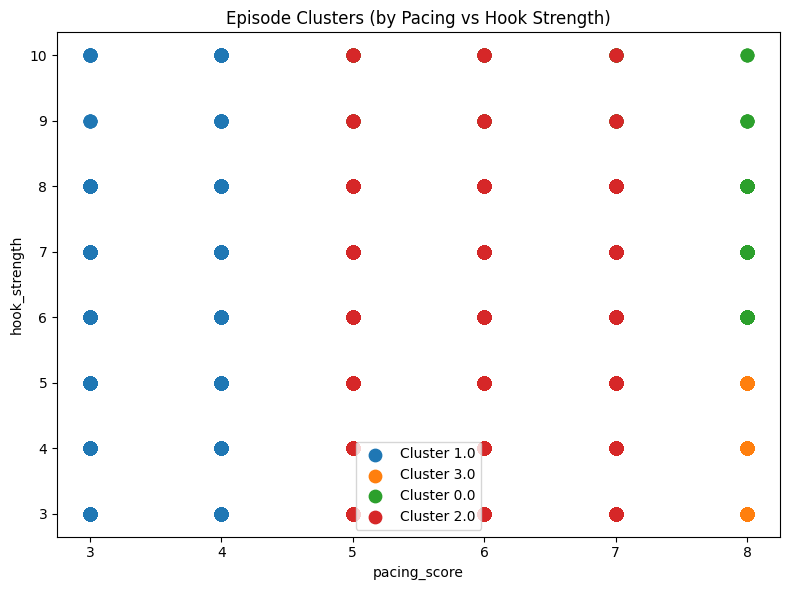

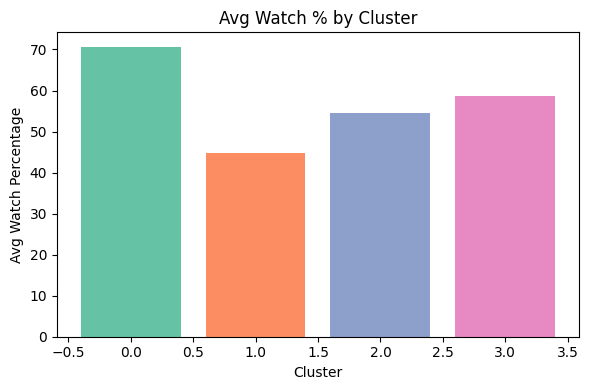

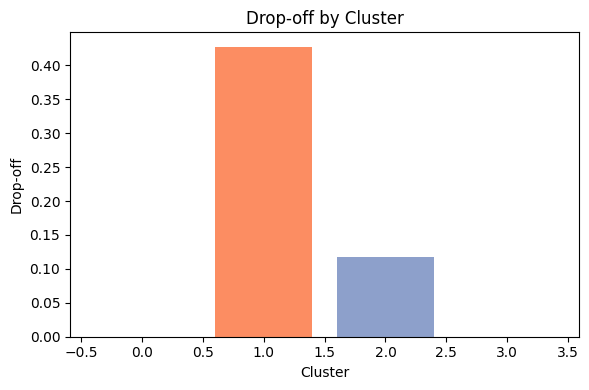

In [21]:
# Visualize cluster separation (2D projection using two key features)
x_feat, y_feat = "pacing_score", "hook_strength"
plot_df = df.dropna(subset=["cluster", x_feat, y_feat])

plt.figure(figsize=(8,6))
for cluster in plot_df["cluster"].unique():
    subset = plot_df[plot_df["cluster"] == cluster]
    plt.scatter(subset[x_feat], subset[y_feat], label=f"Cluster {cluster}", s=80)

plt.title("Episode Clusters (by Pacing vs Hook Strength)") 
plt.xlabel(x_feat) 
plt.ylabel(y_feat) 
plt.legend() 
plt.tight_layout()
plt.show()

# Bar plot (average watch % by cluster)
plot_df = df.dropna(subset=["cluster", "avg_watch_percentage"])
avg_watch = plot_df.groupby("cluster")["avg_watch_percentage"].mean()

plt.figure(figsize=(6,4))
plt.bar(avg_watch.index, avg_watch.values, color=plt.cm.Set2.colors)
plt.title("Avg Watch % by Cluster") 
plt.xlabel("Cluster") 
plt.ylabel("Avg Watch Percentage") 
plt.tight_layout() 
plt.show()

# Bar plot (drop-off by cluster)
plot_df = df.dropna(subset=["cluster", "drop_off"])
avg_dropoff = plot_df.groupby("cluster")["drop_off"].mean()

plt.figure(figsize=(6,4))
plt.bar(avg_dropoff.index, avg_dropoff.values, color=plt.cm.Set2.colors)
plt.title("Drop-off by Cluster") 
plt.xlabel("Cluster") 
plt.ylabel("Drop-off") 
plt.tight_layout() 
plt.show()


# 6. Actionable outputs (print-ready)

In [22]:
# Top drivers from logistic regression (coefficients)
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coef": log_reg.coef_[0]
}).sort_values(by="coef", ascending=False)
print("\nLogistic Regression Coefficients (scaled features):")
print(coef_df)

# Quick narrative hints (example thresholds; refine based on your outputs)
print("\nNarrative Hints:")
print("- High cognitive_load and longer episode_duration_min tend to increase drop-off.")
print("- Strong hook_strength and higher skip_intro (lower friction) tend to reduce drop-off.")
print("- Clusters with balanced pacing and strong hooks show higher avg_watch_percentage.")



Logistic Regression Coefficients (scaled features):
                 feature      coef
7         cognitive_load  5.479947
5            pause_count  1.540083
8     attention_required  1.055302
6           rewind_count  0.076634
2       dialogue_density  0.025335
9             skip_intro -0.009445
4   episode_duration_min -0.030031
3       visual_intensity -0.039632
10        episode_number -0.042712
0           pacing_score -1.381682
1          hook_strength -4.626524

Narrative Hints:
- High cognitive_load and longer episode_duration_min tend to increase drop-off.
- Strong hook_strength and higher skip_intro (lower friction) tend to reduce drop-off.
- Clusters with balanced pacing and strong hooks show higher avg_watch_percentage.
